# Plot Results after Training on CALCE Dataset

This notebook contains code for plotting the RE, RMSE and MAE for different noise levels in a Radar Chart.

## Import Packages

In [5]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns # improves plot aesthetics

## Defaults for Matplotlib

In [2]:
matplotlib.rcParams.update({'font.size': 12})

## Auxiliary Functions

In [3]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    # for d, (y1, y2) in zip(data[1:], ranges[1:]):
    for d, (y1, y2) in zip(data, ranges):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)

    x1, x2 = ranges[0]
    d = data[0]

    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1

    sdata = [d]

    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1

        sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)

    return sdata

def set_rgrids(self, radii, labels=None, angle=None, fmt=None,
               **kwargs):
    """
    Set the radial locations and labels of the *r* grids.
    The labels will appear at radial distances *radii* at the
    given *angle* in degrees.
    *labels*, if not None, is a ``len(radii)`` list of strings of the
    labels to use at each radius.
    If *labels* is None, the built-in formatter will be used.
    Return value is a list of tuples (*line*, *label*), where
    *line* is :class:`~matplotlib.lines.Line2D` instances and the
    *label* is :class:`~matplotlib.text.Text` instances.
    kwargs are optional text properties for the labels:
    %(Text)s
    ACCEPTS: sequence of floats
    """
    # Make sure we take into account unitized data
    radii = self.convert_xunits(radii)
    radii = np.asarray(radii)
    rmin = radii.min()
    # if rmin <= 0:
    #     raise ValueError('radial grids must be strictly positive')

    self.set_yticks(radii)
    if labels is not None:
        self.set_yticklabels(labels)
    elif fmt is not None:
        self.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter(fmt))
    if angle is None:
        angle = self.get_rlabel_position()
    self.set_rlabel_position(angle)
    for t in self.yaxis.get_ticklabels():
        t.update(kwargs)
    return self.yaxis.get_gridlines(), self.yaxis.get_ticklabels()

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i))
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles,
                                         labels=variables, fontsize=22)

        [txt.set_rotation(angle-90) for txt, angle
             in zip(text, angles)]
        [txt.set_y(txt.get_position()[1] -0.1) for txt, angle
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,3))
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            set_rgrids(ax, grid, labels=gridlabel, angle=angles[i])
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax.xaxis.grid(True,color='k',linestyle='--', linewidth=2)
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

## Extract Best Values for Gaussian and Poisson

In [6]:
df = pd.read_csv('results_CALCE.csv')
display(df)

,Noise,Noise Level,RE,RMSE,MAE
0,Gaussian,0.500,0.6600,0.1806,0.0326
1,Gaussian,0.050,0.2000,0.1000,0.0326
2,Gaussian,0.010,0.0820,0.0900,0.0082
3,Gaussian,0.001,0.0523,0.0927,0.0082
4,Speckle,0.500,0.5600,0.1523,0.0234
5,Speckle,0.050,0.1200,0.1030,0.0112
6,Speckle,0.010,0.0808,0.0912,0.0084
7,Speckle,0.001,0.0523,0.0928,0.0087
8,Poisson,0.500,0.3500,0.1651,0.0273
9,Poisson,0.050,0.1062,0.0727,0.0273


In [25]:
metrics = ["RE", "RMSE", "MAE"]
gaussian = df.loc[df['Noise'] == 'Gaussian'][metrics]
gaussian = gaussian.loc[gaussian['RE'] == gaussian['RE'].min()].to_numpy()[0]
display(gaussian)

poisson = df.loc[df['Noise'] == 'Poisson'][metrics]
poisson = poisson.loc[poisson['RE'] == poisson['RE'].min()].to_numpy()[0]
display(poisson)

array([0.0523, 0.0927, 0.0082])

array([0.033 , 0.1519, 0.0242])

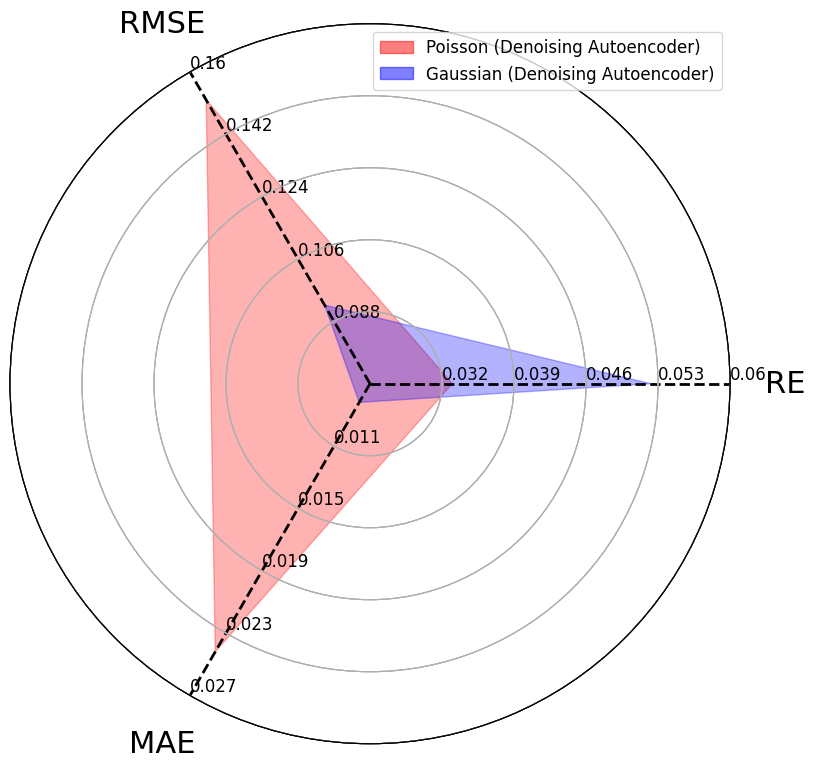

In [26]:
ranges = [(0.025, 0.06), (0.07, 0.16), (0.007, 0.027)]
# plotting
fig1 = plt.figure(figsize=(8, 8))
radar = ComplexRadar(fig1, metrics, ranges)
radar.fill(poisson, '-',  color='r', alpha=0.3)
radar.fill(gaussian, '-', color='b', alpha=0.3)

poisson_patch = mpatches.Patch(color='r', alpha=0.5, label='Poisson (Denoising Autoencoder)')
gaussian_patch = mpatches.Patch(color='b', alpha=0.5, label='Gaussian (Denoising Autoencoder)')
plt.legend(handles=[poisson_patch, gaussian_patch])
plt.savefig('CALCE_Radar.png', bbox_inches='tight', pad_inches=0)
plt.show()